# Preparação de Dados
Faça o download do dataset UCI HAR.

Carregue os dados em Python.

Identifique número de amostras, atributos e classes.


In [1]:
!pip install --upgrade bottleneck --break-system-packages


Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install -r /home/emilly/Trabalho_2_Tp/Redu-o-de-Dimensionalidade-na-Base-UCI-HAR/requirements.txt --break-system-packages


Defaulting to user installation because normal site-packages is not writeable


In [2]:
#Importação das bibliotecas necessárias
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

/home/emilly/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
# Caminho base para o dataset
dataset_path = "/home/emilly/Trabalho_2_Tp/Redu-o-de-Dimensionalidade-na-Base-UCI-HAR/UCI HAR Dataset"
# dataset_path = 'C:\\Users\\walis\\Documents\\Facul\\Redu-o-de-Dimensionalidade-na-Base-UCI-HAR\\UCI HAR Dataset'


In [4]:

# Features
features = pd.read_csv(os.path.join(dataset_path, 'UCI HAR Dataset/features.txt'), 
                       sep=r'\s+', header=None, names=['id','name'])
feature_names = features['name'].tolist()

# Labels das atividades
activity_labels = pd.read_csv(os.path.join(dataset_path, 'UCI HAR Dataset/activity_labels.txt'), 
                              sep=r'\s+', header=None, names=['id','label'])
class_names = activity_labels['label'].tolist()

# Carregar dados de treino
X_train = pd.read_csv(os.path.join(dataset_path, 'UCI HAR Dataset/train/X_train.txt'), 
                      sep=r'\s+', header=None)
y_train = pd.read_csv(os.path.join(dataset_path, 'UCI HAR Dataset/train/y_train.txt'), 
                      sep=r'\s+', header=None)

# Carregar dados de teste
X_test = pd.read_csv(os.path.join(dataset_path, 'UCI HAR Dataset/test/X_test.txt'), 
                     sep=r'\s+', header=None)
y_test = pd.read_csv(os.path.join(dataset_path, 'UCI HAR Dataset/test/y_test.txt'), 
                     sep=r'\s+', header=None)

# Combinar dados
X = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)
y = pd.concat([y_train, y_test], axis=0).reset_index(drop=True)

# Checar consistência
assert X.shape[1] == len(feature_names), "Número de colunas de X diferente do número de features!"

# Atribuir nomes
X.columns = feature_names

# Informações
print("Número de amostras:", X.shape[0])
print("Número de atributos:", X.shape[1])
print("Número de classes:", len(class_names))
print("Classes:", class_names)

Número de amostras: 10299
Número de atributos: 561
Número de classes: 6
Classes: ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']


# Pré-processamento
Normalize os dados utilizando StandardScaler (importante para o PCA).

Separe os dados em atributos (X) e rótulos (y) (PCA).

In [5]:

# Inicializa o StandardScaler
scaler = StandardScaler()

# Normaliza os atributos (X)
X_scaled = scaler.fit_transform(X)

# X_scaled será usado para PCA
print("Shape dos dados normalizados:", X_scaled.shape)

# y já está separado e pronto para uso
print("Shape dos rótulos:", y.shape)

Shape dos dados normalizados: (10299, 561)
Shape dos rótulos: (10299, 1)


# Redução de Dimensionalidade com PCA

Aplique o PCA para reduzir os 561 atributos para 2 componentes principais.

Visualize os dados em um gráfico de dispersão 2D, colorindo cada ponto de acordo com a atividade (classe).

Calcule a variância explicada pelos componentes principais.

Determine quantos componentes são necessários para explicar pelo menos 90% da variância.

Variância explicada pelos 2 componentes: 0.5698


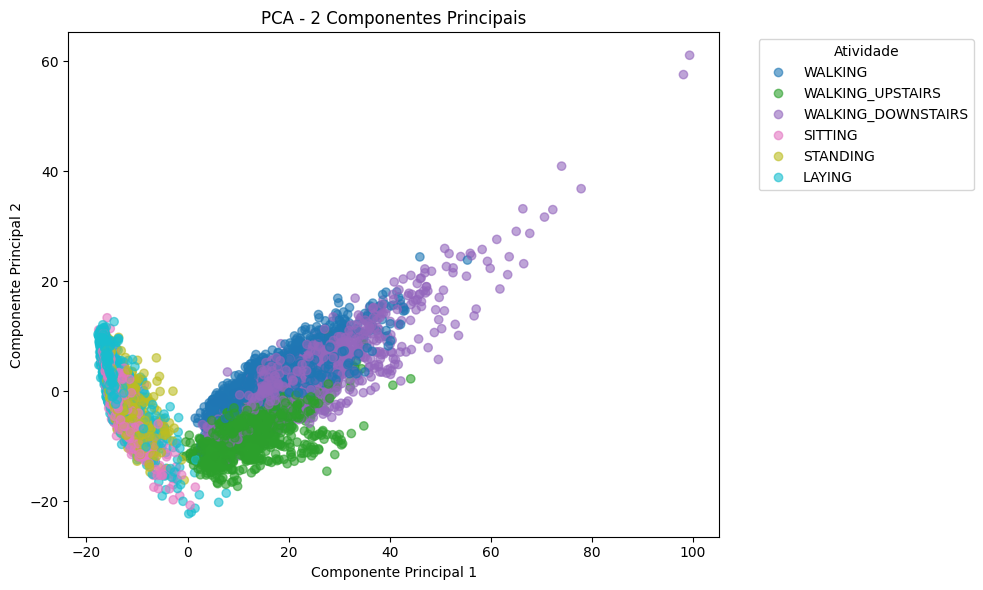

Número de componentes para >=90% da variância: 65


In [6]:

# Aplica PCA para 2 componentes principais
pca_2 = PCA(n_components=2)
X_pca_2 = pca_2.fit_transform(X_scaled)

# Variância explicada pelos 2 componentes
explained_var_2 = pca_2.explained_variance_ratio_
print(f"Variância explicada pelos 2 componentes: {explained_var_2.sum():.4f}")

# Visualização 2D dos dados
plt.figure(figsize=(10,6))
scatter = plt.scatter(X_pca_2[:,0], X_pca_2[:,1], c=y.values.ravel(), cmap='tab10', alpha=0.6)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('PCA - 2 Componentes Principais')
plt.legend(handles=scatter.legend_elements()[0], labels=class_names, title="Atividade", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Determina quantos componentes explicam pelo menos 90% da variância
pca_full = PCA().fit(X_scaled)
cumulative_var = np.cumsum(pca_full.explained_variance_ratio_)
n_components_90 = np.argmax(cumulative_var >= 0.90) + 1
print(f"Número de componentes para >=90% da variância: {n_components_90}")

# Seleção de Características

### Recursive Feature Elimination (RFE)

Aplique o RFE com um classificador de sua escolha (ex.: Logistic Regression ou Random Forest).

Reduza progressivamente o número de atributos e avalie o impacto.

Identifique o subconjunto de atributos mais relevantes.

In [7]:

# Classificadores escolhidos
clf_rf = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)
clf_log = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)

Melhor número de atributos RF: 474 (Acurácia: 0.9334)
Melhor número de atributos LogReg: 146 (Acurácia: 0.9582)

Atributos selecionados pelo Random Forest:
['tBodyAcc-mean()-X' 'tBodyAcc-mean()-Y' 'tBodyAcc-mean()-Z'
 'tBodyAcc-std()-X' 'tBodyAcc-std()-Y' 'tBodyAcc-std()-Z'
 'tBodyAcc-mad()-X' 'tBodyAcc-mad()-Y' 'tBodyAcc-mad()-Z'
 'tBodyAcc-max()-X' 'tBodyAcc-max()-Y' 'tBodyAcc-max()-Z'
 'tBodyAcc-min()-X' 'tBodyAcc-min()-Y' 'tBodyAcc-min()-Z' 'tBodyAcc-sma()'
 'tBodyAcc-energy()-X' 'tBodyAcc-energy()-Y' 'tBodyAcc-energy()-Z'
 'tBodyAcc-iqr()-X' 'tBodyAcc-iqr()-Y' 'tBodyAcc-iqr()-Z'
 'tBodyAcc-entropy()-X' 'tBodyAcc-entropy()-Y' 'tBodyAcc-entropy()-Z'
 'tBodyAcc-arCoeff()-X,1' 'tBodyAcc-arCoeff()-X,4'
 'tBodyAcc-arCoeff()-Y,1' 'tBodyAcc-arCoeff()-Y,4'
 'tBodyAcc-arCoeff()-Z,1' 'tBodyAcc-arCoeff()-Z,3'
 'tBodyAcc-arCoeff()-Z,4' 'tBodyAcc-correlation()-X,Y'
 'tBodyAcc-correlation()-X,Z' 'tBodyAcc-correlation()-Y,Z'
 'tGravityAcc-mean()-X' 'tGravityAcc-mean()-Y' 'tGravityAcc-mean()-Z'
 '

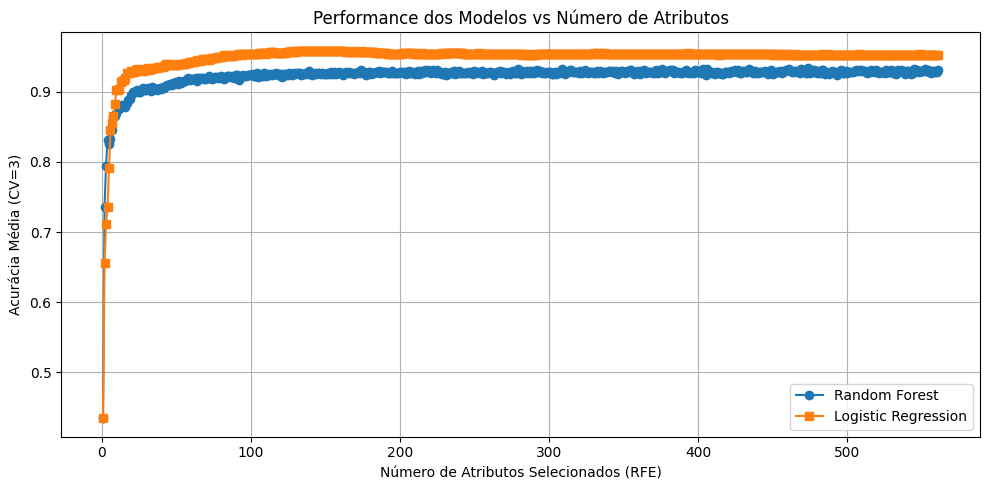

In [8]:
from sklearn.feature_selection import RFECV

rfecv_rf = RFECV(estimator=clf_rf, step=1, cv=3, scoring='accuracy', n_jobs=-1)
rfecv_rf.fit(X_scaled, y.values.ravel())

rfecv_log = RFECV(estimator=clf_log, step=1, cv=3, scoring='accuracy', n_jobs=-1)
rfecv_log.fit(X_scaled, y.values.ravel())

# Resultados
print(f"Melhor número de atributos RF: {rfecv_rf.n_features_} "
      f"(Acurácia: {max(rfecv_rf.cv_results_['mean_test_score']):.4f})")
print(f"Melhor número de atributos LogReg: {rfecv_log.n_features_} "
      f"(Acurácia: {max(rfecv_log.cv_results_['mean_test_score']):.4f})")

print("\nAtributos selecionados pelo Random Forest:")
print(np.array(X.columns)[rfecv_rf.support_])

print("\nAtributos selecionados pela Logistic Regression:")
print(np.array(X.columns)[rfecv_log.support_])

# Visualização
plt.figure(figsize=(10,5))
plt.plot(range(1, len(rfecv_rf.cv_results_["mean_test_score"]) + 1),
         rfecv_rf.cv_results_["mean_test_score"],
         marker='o', label='Random Forest')

plt.plot(range(1, len(rfecv_log.cv_results_["mean_test_score"]) + 1),
         rfecv_log.cv_results_["mean_test_score"],
         marker='s', label='Logistic Regression')

plt.xlabel('Número de Atributos Selecionados (RFE)')
plt.ylabel('Acurácia Média (CV=3)')
plt.title('Performance dos Modelos vs Número de Atributos')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Lasso (L1 Regularization) 

Aplique um modelo de regressão logística ou regressão linear com regularização L1 (Lasso).

Analise os coeficientes para identificar quais atributos foram zerados pelo modelo.

Compare o conjunto de variáveis selecionadas com o resultado do RFE.

In [9]:
from sklearn.linear_model import LogisticRegression

clf_l1 = LogisticRegression(
    penalty='l1',
    solver='saga',          
    multi_class='multinomial',
    max_iter=1000,
    random_state=42
)

# Treinamento
clf_l1.fit(X_scaled, y.values.ravel())

# Coeficientes
coef_l1 = clf_l1.coef_  # Shape: n_classes x n_features
coef_sum = np.sum(np.abs(coef_l1), axis=0)

coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coef_sum': coef_sum
})

# Atributos zerados e não zerados
atributos_zerados = coef_df[coef_df['Coef_sum'] == 0]['Feature'].tolist()
atributos_nao_zerados = coef_df[coef_df['Coef_sum'] != 0]['Feature'].tolist()

print(f"Número de atributos zerados pelo L1: {len(atributos_zerados)}")
print(f"Atributos zerados:\n{atributos_zerados[:20]} ...")
print(f"Número de atributos não zerados: {len(atributos_nao_zerados)}")
print(f"Atributos não zerados:\n{atributos_nao_zerados[:20]} ...")

/home/emilly/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Número de atributos zerados pelo L1: 32
Atributos zerados:
['tBodyGyro-energy()-Y', 'tBodyGyroMag-std()', 'tBodyGyroJerkMag-energy()', 'fBodyAcc-min()-Y', 'fBodyAcc-energy()-Z', 'fBodyAcc-bandsEnergy()-25,32', 'fBodyAcc-bandsEnergy()-25,48', 'fBodyAcc-bandsEnergy()-41,48', 'fBodyAcc-bandsEnergy()-57,64', 'fBodyAcc-bandsEnergy()-49,64', 'fBodyAcc-bandsEnergy()-25,32', 'fBodyAcc-bandsEnergy()-41,48', 'fBodyAcc-bandsEnergy()-49,56', 'fBodyAcc-bandsEnergy()-49,64', 'fBodyAcc-bandsEnergy()-25,48', 'fBodyAccJerk-bandsEnergy()-25,32', 'fBodyAccJerk-bandsEnergy()-25,48', 'fBodyAccJerk-bandsEnergy()-17,24', 'fBodyAccJerk-bandsEnergy()-33,40', 'fBodyAccJerk-bandsEnergy()-41,48'] ...
Número de atributos não zerados: 529
Atributos não zerados:
['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X', 'tBodyAcc-max()-Y', 'tBodyAcc-max()-Z', 'tBodyAcc-min(

/home/emilly/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


# Visualizações
Gráfico de dispersão em 2D com PCA.

Gráfico da variância explicada acumulada (scree plot).

Gráfico comparando a performance do modelo ao variar o número de atributos no RFE.

Visualização dos coeficientes do Lasso (quais atributos permaneceram)

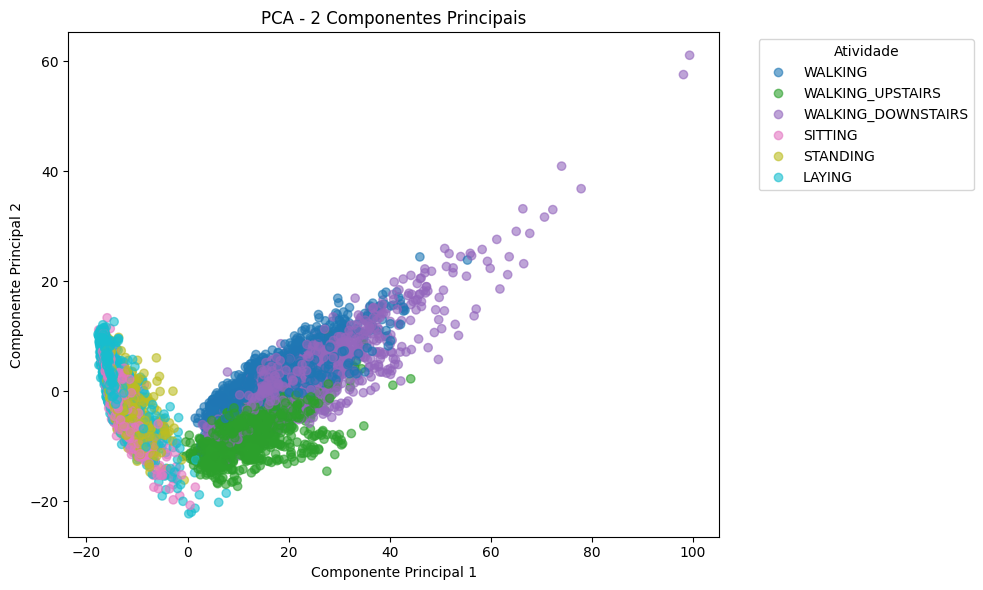

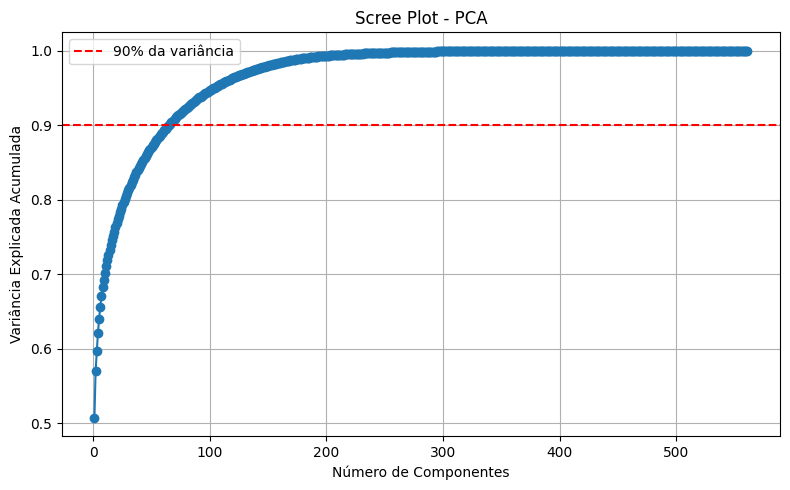

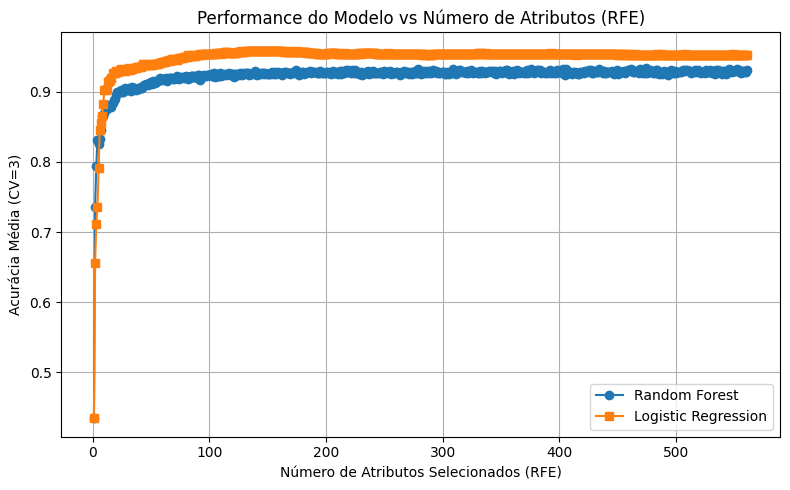

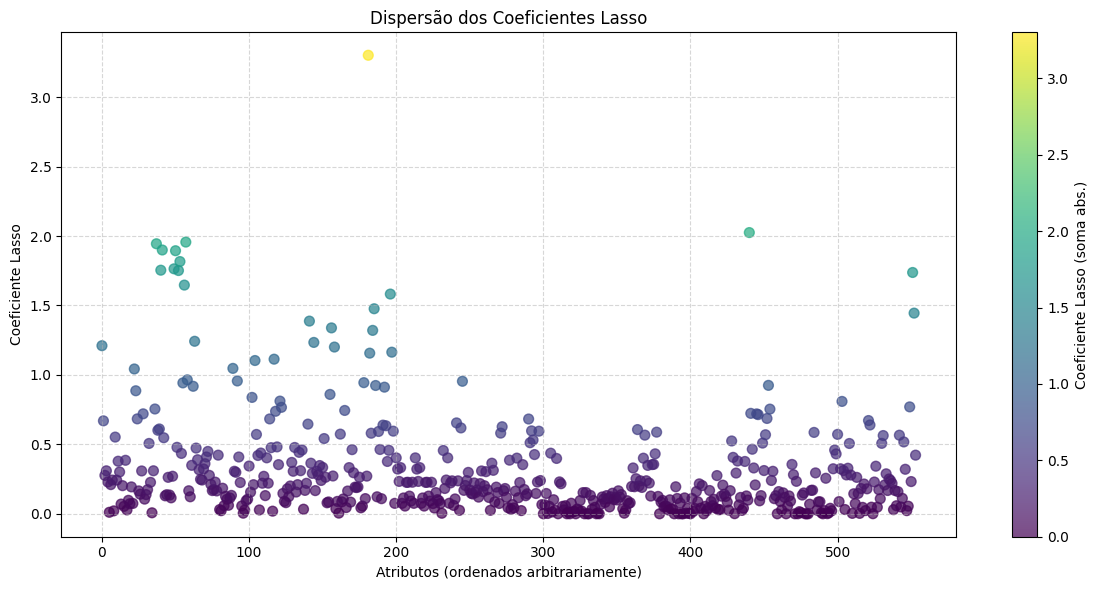

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Gráfico de dispersão em 2D com PCA

plt.figure(figsize=(10,6))
scatter = plt.scatter(X_pca_2[:,0], X_pca_2[:,1], c=y.values.ravel(), cmap='tab10', alpha=0.6)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('PCA - 2 Componentes Principais')
plt.legend(handles=scatter.legend_elements()[0], labels=class_names, title="Atividade",
           bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 2. Scree plot: variância explicada acumulada

plt.figure(figsize=(8,5))
plt.plot(np.arange(1, len(cumulative_var)+1), cumulative_var, marker='o')
plt.axhline(0.9, color='r', linestyle='--', label='90% da variância')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Acumulada')
plt.title('Scree Plot - PCA')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Performance do modelo ao variar número de atributos no RFE

plt.figure(figsize=(8,5))
plt.plot(range(1, len(rfecv_rf.cv_results_["mean_test_score"])+1),
         rfecv_rf.cv_results_["mean_test_score"], marker='o', label='Random Forest')
plt.plot(range(1, len(rfecv_log.cv_results_["mean_test_score"])+1),
         rfecv_log.cv_results_["mean_test_score"], marker='s', label='Logistic Regression')
plt.xlabel('Número de Atributos Selecionados (RFE)')
plt.ylabel('Acurácia Média (CV=3)')
plt.title('Performance do Modelo vs Número de Atributos (RFE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Visualização dos coeficientes do Lasso (atributos não zerados)
df_coef = pd.DataFrame({
    'Feature': X.columns,
    'Coef_sum': coef_sum
})

df_coef_filtrado = df_coef[df_coef['Feature'].isin(atributos_nao_zerados)]

df_coef_filtrado_sorted = df_coef_filtrado.sort_values('Coef_sum', ascending=False)

indices = np.arange(len(df_coef_filtrado))


plt.figure(figsize=(12,6))
plt.scatter(indices, df_coef_filtrado['Coef_sum'], 
            s=50,             
            c=df_coef_filtrado['Coef_sum'], 
            cmap='viridis',    
            alpha=0.7)
plt.colorbar(label='Coeficiente Lasso (soma abs.)')
plt.xlabel('Atributos (ordenados arbitrariamente)')
plt.ylabel('Coeficiente Lasso')
plt.title('Dispersão dos Coeficientes Lasso')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()